# 1.5 Tic Tac Toe 

Reference: http://incompleteideas.net/book/RLbook2020trimmed.pdf page 30

Consider the game of tic-tac-toe. A player with the [optimal strategy](https://xkcd.com/832/) can play to never lose for both sides.

But playing the optimal strategy against an imperfect player does not guarantee a win, even if there are flaws in the opponent's strategy. This is because a player following the optimal strategy assumes that the opponent is also following the optimal strategy, but the way to beat this opponent may be to first make a sub-optimal move.

Assume we are playing against such an imperfect player. How might we train an agent to discover the flaws in the opponent's strategy and learn to always win? 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

## The game
Here is a simple implementation of tic tac toe, with some added code to handle the interaction with player agents.

In [2]:
class TicTacToe: 
    def __init__(self, player_X=None, player_O=None, verbose=False):
        self.board = [None] * 9
        self.verbose = verbose
        self.player_X = player_X; player_X.join(self, "X") if player_X else None
        self.player_O = player_O; player_O.join(self, "O") if player_O else None
        self.current_marker = "X"
        self.current_player = player_X
        self.winner_marker = None
        self.winner_player = None
        self.last_move = None
        if verbose:
            self.print()

    def move(self, marker, position):
        if marker not in ["X", "O"]:
            raise ValueError("Invalid marker")
        if self.done():
            raise ValueError("Game is over")
        if marker != self.current_marker:
            raise ValueError("Not your turn")
        if self.board[position]:
            raise ValueError("Position taken")
        
        # Update board
        self.board[position] = marker
        self.last_move = position
        
        # Check for winner
        if self.is_win():
            self.winner_marker = self.current_marker
            self.winner_player = self.current_player
        else:
            self.current_marker = "X" if self.current_marker == "O" else "O"
            self.current_player = self.player_X if self.current_player == self.player_O else self.player_O
        
        if self.verbose:
            self.print()

    def is_win(self, marker=None, board=None):
        marker = marker or self.current_marker
        board = board or self.board
        rows = [[board[0], board[1], board[2]], [board[3], board[4], board[5]], [board[6], board[7], board[8]]]
        columns = [[board[0], board[3], board[6]], [board[1], board[4], board[7]], [board[2], board[5], board[8]]]
        diagonals = [[board[0], board[4], board[8]], [board[2], board[4], board[6]]]
        return [marker, marker, marker] in rows + columns + diagonals

    def next(self):
        return self.current_player.move()

    def play(self):
        while not self.done():
            self.next()
        return self.winner_player

    def done(self):
        return self.winner_marker or all(self.board)

    def print(self):
        print("-------------")
        for i in range(3):
            print("|", end="")
            for j in range(3):
                if self.last_move == i*3+j:
                    print(f"({self.board[i*3+j] or ' '})|", end="")
                else:
                    print(f" {self.board[i*3+j] or ' '} |", end="")
            print("\n-------------")
        if self.winner_marker:
            print(f"Player {self.winner_marker} won!")
        elif all(self.board):
            print("It's a tie!")
        else:
            print(f"Player {self.current_marker}'s turn")

Here is how you would play the game manually.

In [3]:
game = TicTacToe(verbose=True)
game.move("X", 4)
game.move("O", 0)
game.move("X", 1)
game.move("O", 2)
game.move("X", 7)

-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |   |   |
-------------
Player X's turn
-------------
|   |   |   |
-------------
|   |(X)|   |
-------------
|   |   |   |
-------------
Player O's turn
-------------
|(O)|   |   |
-------------
|   | X |   |
-------------
|   |   |   |
-------------
Player X's turn
-------------
| O |(X)|   |
-------------
|   | X |   |
-------------
|   |   |   |
-------------
Player O's turn
-------------
| O | X |(O)|
-------------
|   | X |   |
-------------
|   |   |   |
-------------
Player X's turn
-------------
| O | X | O |
-------------
|   | X |   |
-------------
|   |(X)|   |
-------------
Player X won!


## The imperfect player
Here is a player with an imperfecct strategy based on simple heuristics.

In [44]:
class ImperfectPlayer:
    def __init__(self, symmetric=False):
        self.symmetric = symmetric

    def join(self, game, marker):
        self.game = game
        self.marker = marker
        self.opponent_marker = "O" if self.marker == "X" else "X"

    def move(self):
        self.game.move(self.marker, self.best_move())

    # Flawed strategy based on simple heuristics
    def best_move(self):
        # Win if possible
        for i in range(9):
            if self.game.board[i] is None and self.can_win(i, self.marker):
                return i
        
        # Block opponent from winning
        for i in range(9):
            if self.game.board[i] is None and self.can_win(i, self.opponent_marker):
                return i

        # If first move, take a corner
        if self.game.board.count(None) == 9:
            rand = np.random.choice([0, 2, 6, 8])
            return rand if self.symmetric else 0
        
        # If second move, take center if available, otherwise take a corner
        if self.game.board.count(None) == 8:
            if self.game.board[4] is None:
                return 4
            else:
                rand = np.random.choice([0, 2, 6, 8])
                return rand if self.symmetric else 0 

        # Take center if available
        if self.game.board[4] is None:
            return 4

        # Take a corner if available
        available_corners = [i for i in [0, 6, 2, 8] if self.game.board[i] is None]
        if available_corners:
            rand = np.random.choice(available_corners)
            return rand if self.symmetric else available_corners[0]

        # Take an edge if available
        available_edges = [i for i in [1, 5, 3, 7] if self.game.board[i] is None]
        if available_edges:
            rand = np.random.choice(available_edges)
            return rand if self.symmetric else available_edges[0]
        
    def can_win(self, move, marker):
        board = self.game.board[:]
        board[move] = marker
        return self.game.is_win(marker, board)


## The agent
Here is how we create the reinforcement learning agent using a "value function".

The agent has a lookup table called `values` which contains a value for each possible state of the game. The value of a board state is the latest estimate of the probability of winning from that state. During play, the agent simply looks up the value of each possible next board state and moves towards the next board state with the highest value. 

The table is initialized with X wins = 1, O wins = 0, and all other states = 0.5. After each game with the opponent, we `update` the values of each board state encountered during the game by brining the value of earlier moves closer to the values of later moves. The exact update formula is $ V(S_t) \leftarrow  V(S_t) + \alpha [V(S_{t+1}) - V(S_t)] $ where $S_t$ is the current state, $S_{t+1}$ is the next state, and `alpha` is the learning rate.

The parameter `epsilon` controls how "greedy" we want our agent to be. When deciding the next move, the agent will sometimes (at rate `episilon`) decide to "explore" and choose a random move instead of the move with the highest value. By default, we only update the values from non-exploratory moves.


In [304]:
class Agent:
    def __init__(self, alpha, alpha_decay, epsilon=0.1, epsilon_decay=1, symmetric=False, learn_from_exploration=False, verbose=False):
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.exploration = True
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.marker = None
        self.symmetric = symmetric
        self.learn_from_exploration = learn_from_exploration
        self.verbose = verbose

        # Initialize state values
        self.values = {}
        for board in product([None, "X", "O"], repeat=9):
            rows = [[board[0], board[1], board[2]], [board[3], board[4], board[5]], [board[6], board[7], board[8]]]
            columns = [[board[0], board[3], board[6]], [board[1], board[4], board[7]], [board[2], board[5], board[8]]]
            diagonals = [[board[0], board[4], board[8]], [board[2], board[4], board[6]]]
            if ["X", "X", "X"] in rows + columns + diagonals:
                self.values[board] = 1
            elif ["O", "O", "O"] in rows + columns + diagonals:
                self.values[board] = 0
            else:
                self.values[board] = 0.5
            
    def join(self, game, marker):
        self.game = game
        self.verbose = self.verbose or self.game.verbose
        self.marker = marker
        self.opponent_marker = "O" if self.marker == "X" else "X"
        self.states = []

    def move(self):
        if self.verbose:
            self.inspect()
            
        move = None
        free = [i for i in range(9) if self.game.board[i] is None]
        explore = self.exploration and np.random.rand() < self.epsilon
        if explore:
            move = np.random.choice(free)
        else:
            moves = [(i, self.values[tuple(self.game.board[:i] + [self.marker] + self.game.board[i+1:])]) for i in free]
            best_value = max(moves, key=lambda x: x[1])[1] if self.marker == "X" else min(moves, key=lambda x: x[1])[1]
            best_moves = [move for move, value in moves if value == best_value]
            move = np.random.choice(best_moves)
        
        self.game.move(self.marker, move)
        self.states.append((self.game.board[:], explore))

    def update(self):
        if self.states[-1][0] != self.game.board:
            self.states.append((self.game.board[:], False))

        # update states in reverse order
        for i in reversed(range(1, len(self.states))):
            next_state, exploratory = self.states[i]
            state, _ = self.states[i-1]
            # print(f"updating {state} <- {next_state} exp:{exploratory}")
            # only update if the move was not exploratory
            if self.learn_from_exploration or not exploratory:
                self.values[tuple(state)] += self.alpha * (self.values[tuple(next_state)] - self.values[tuple(state)])
                # update symmetric states
                if self.symmetric:
                    for s in self.symmetric_states(state):
                        # print(f"also updating {s} <- {next_state} exp:{exploratory}")
                        self.values[tuple(s)] += self.alpha * (self.values[tuple(next_state)] - self.values[tuple(s)])
        
        self.alpha *= self.alpha_decay
        self.epsilon *= self.epsilon_decay
        self.states = []

    def symmetric_states(self, board):
        rotations = [
            [board[6], board[3], board[0], board[7], board[4], board[1], board[8], board[5], board[2]], # 90
            [board[8], board[7], board[6], board[5], board[4], board[3], board[2], board[1], board[0]], # 180
            [board[2], board[5], board[8], board[1], board[4], board[7], board[0], board[3], board[6]], # 270
        ]
        reflections = [
            [board[2], board[1], board[0], board[5], board[4], board[3], board[8], board[7], board[6]], # horizontal
            [board[6], board[7], board[8], board[3], board[4], board[5], board[0], board[1], board[2]], # vertical
            [board[8], board[5], board[2], board[7], board[4], board[1], board[6], board[3], board[0]], # diagonal
            [board[0], board[3], board[6], board[1], board[4], board[7], board[2], board[5], board[8]], # anti-diagonal
        ]
        
        # return deduplicated list of symmetric states (removing self)
        return list(set([tuple(s) for s in rotations + reflections if s != board]))
    
    def inspect(self, board=None):
        board = board or self.game.board
        print("-------------------")
        for i in range(3):
            print("|", end="")
            for j in range(3):
                if board[i*3+j] is not None:
                    print(f"  {board[i*3+j] or ' '}  |", end="")
                else: 
                    future = board[:]
                    future[i*3+j] = self.marker
                    print(f"{self.values[tuple(future)]:.3f}|", end="")
            print("\n-------------------")

    def disable_exploration(self):
        self.exploration = False
    
    def enable_exploration(self):
        self.exploration = True        

Below we set up our training and test harness. 

At a high level, we `train` by playing a number of games against the opponent, updating the value function of our agent after each game. 

To track our progress, we `test` our agent throughout training to see how it does against the opponent with exploration turned off so it plays its best strategy.

In [134]:
# Test an agent against an opponent over n games (no learning, exploration disabled)
def test(agent, opponent, n):
    agent.disable_exploration()
    rewards = []
    for _ in range(n):
        game = TicTacToe(player_X=agent, player_O=opponent)
        winner = game.play()
        rewards.append(1 if winner == agent else -1 if winner == opponent else 0)
    agent.enable_exploration()
    return np.mean(rewards) 

# Train an agent against an opponent over n games, testing it every 1% of the way 
def train(agent, opponent, n):
    rewards = [] 
    for i in tqdm(range(n)):
        game = TicTacToe(player_X=agent, player_O=opponent)
        game.play()
        agent.update()
        if i % (n/100) == 0:
            rewards.append((i, test(agent, opponent, 10)))
    return rewards

# Plot the rewards of multiple trials
def plot(rewards):
    plt.figure(figsize=(10, 5))
    for i in range(len(rewards)):
        plt.plot(*zip(*rewards[i]), label=f"Trial {i+1}")
    plt.xlabel("Episodes")
    plt.ylabel("Average reward")
    plt.legend()
    plt.show()

Below we train our agent against the opponent over 100 games. We repeat the experiment 5 times to make sure we aren't getting fooled by randomness.

We observe that the agents all start off losing as it is essentially playing randomly. But very quickly all of our agents figure out how to win.

100%|██████████| 100/100 [00:00<00:00, 1144.28it/s]


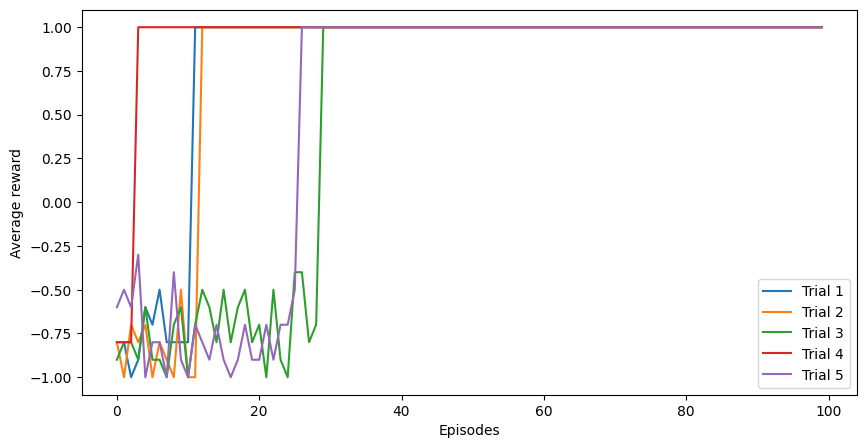

In [239]:
n = 100
opponent = ImperfectPlayer()
rewards = {}
for i in range(5):
    np.random.seed(i)
    agent = Agent(alpha=0.1, alpha_decay=1-1/n, epsilon=0.1)
    rewards[i] = train(agent, opponent, n)

plot(rewards)

## Exercise 1.1 Self Play

*Suppose, instead of playing against a random opponent, the reinforcement learning algorithm described above played against itself, with both sides learning. What do you think would happen in this case? Would it learn a different policy for selecting moves?*

If we train two agents to play against each other (with no shared state), the agents will dynamically co-evolve their strategies. After each game, both agent will update their value functions based on the observed strategy (including random explorations) of the opponent in the previous game. 

Whatever strategy is learned during self play is going to be different from what is learned training against the imperfect player, since it is unlikely that either opponent is going to have the exact same strategy (with the same imperfection) as the imperfect player.

### Experiment 1: Alpha Decay

If we let alpha decay to 0 like before, then the strategies will eventually settle as learning stops.

Below we run the self-play experiment 5 times, and we observe that the agents converge on a solution that ties with the opponent but does not win.

Since we are training against a different opponent each game, we expect the agents to converge on a strategy that maximizes the average value of all possible next states. Specifically, we can see this by inspecting the empty board values for the agent and see that it always prefers the center. This is similar to but different than the minmax strategy which gives no preference to which position you start with.


In [196]:
# Train agent1 against agent2 over n games, testing agent1 against the opponent every 1% of the way 
def self_train(agent1, agent2, opponent, n):
    rewards = [] 
    for i in tqdm(range(n)):
        game = TicTacToe(player_X=agent1, player_O=agent2)
        game.play()
        agent1.update()
        agent2.update()
        if i % (n/100) == 0:
            rewards.append((i, test(agent1, opponent, 100)))
            
    return rewards

100%|██████████| 10000/10000 [00:01<00:00, 5502.61it/s]


-------------------
|0.579|0.569|0.537|
-------------------
|0.528|0.616|0.576|
-------------------
|0.545|0.578|0.554|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5585.86it/s]


-------------------
|0.573|0.545|0.567|
-------------------
|0.567|0.601|0.541|
-------------------
|0.545|0.533|0.521|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5432.82it/s]


-------------------
|0.582|0.517|0.574|
-------------------
|0.529|0.608|0.563|
-------------------
|0.553|0.550|0.562|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5396.95it/s]


-------------------
|0.563|0.551|0.555|
-------------------
|0.541|0.605|0.524|
-------------------
|0.524|0.571|0.577|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5562.00it/s]

-------------------
|0.574|0.560|0.521|
-------------------
|0.543|0.601|0.536|
-------------------
|0.574|0.555|0.591|
-------------------


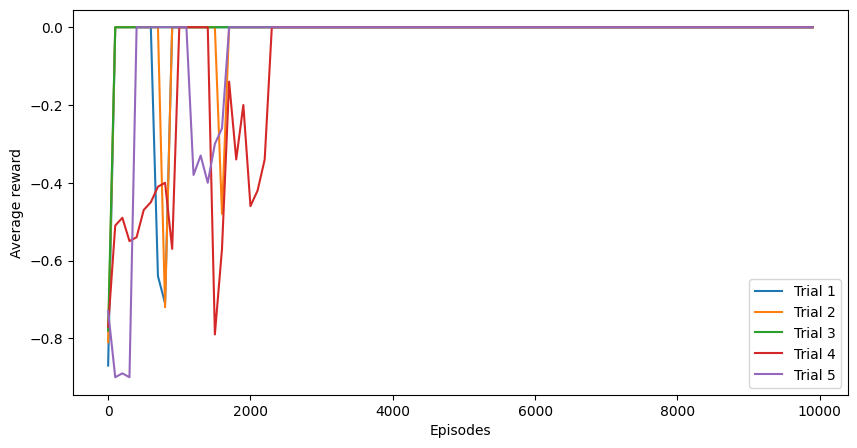

In [218]:
n = 10000
opponent = ImperfectPlayer()
rewards = {}
for i in range(5):
    np.random.seed(i)
    agent1 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1)
    agent2 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1)
    rewards[i] = self_train(agent1, agent2, opponent, n)
    agent1.inspect([None] * 9)
plot(rewards)

If we examine a game played by one of the agents against the opponent, we can see that it plays optimally (in the sense that it does not make mistakes which will essentially force a tie). But is unable to take advantage of the opponent's weakness which just isn't along the trajectory of the agent's optimal play.

In [219]:
game = TicTacToe(player_X=agent1, player_O=opponent, verbose=True)
game.play()

-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |   |   |
-------------
Player X's turn
-------------------
|0.574|0.560|0.521|
-------------------
|0.543|0.601|0.536|
-------------------
|0.574|0.555|0.591|
-------------------
-------------
|   |   |   |
-------------
|   |(X)|   |
-------------
|   |   |   |
-------------
Player O's turn
-------------
|(O)|   |   |
-------------
|   | X |   |
-------------
|   |   |   |
-------------
Player X's turn
-------------------
|  O  |0.582|0.500|
-------------------
|0.500|  X  |0.508|
-------------------
|0.502|0.500|0.500|
-------------------
-------------
| O |(X)|   |
-------------
|   | X |   |
-------------
|   |   |   |
-------------
Player O's turn
-------------
| O | X |   |
-------------
|   | X |   |
-------------
|   |(O)|   |
-------------
Player X's turn
-------------------
|  O  |  X  |0.504|
-------------------
|0.503|  X  |0.501|
-------------------
|0.545|  O  |0.501|
-------------------
----------

### Experiment 1: Epsilon Decay

If we don't decay alpha, our strategies will not settle because learning stops. If we set epsilon to 1 and let it decay to 0, then the two agents will be able to explore much more and potentially oscillate around the minmax solution.

Below we run the self-play experiment 5 times and observe that the agents are able to learn how to not lose quickly, and towards the end even sometimes be able to beat the opponent. This makes sense since we expect the agents to be playing very close to minmax (which will tie) but sometimes chances into having a slight bias towards a trajectory of optimal play that does take advantage of the opponent's weakness.

If we examine the values for the agent's empty board states, we can see that the values for all positions are very close to equal. This is to be expected if the agent has learned a strategy that is close to minmax.

100%|██████████| 10000/10000 [00:01<00:00, 5649.99it/s]


-------------------
|0.508|0.508|0.508|
-------------------
|0.508|0.524|0.508|
-------------------
|0.508|0.508|0.508|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5532.31it/s]


-------------------
|0.506|0.506|0.506|
-------------------
|0.506|0.511|0.506|
-------------------
|0.506|0.506|0.506|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5459.58it/s]


-------------------
|0.504|0.504|0.504|
-------------------
|0.504|0.504|0.504|
-------------------
|0.504|0.504|0.504|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5586.14it/s]


-------------------
|0.506|0.506|0.506|
-------------------
|0.506|0.522|0.506|
-------------------
|0.506|0.506|0.506|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 5587.06it/s]

-------------------
|0.505|0.505|0.505|
-------------------
|0.505|0.506|0.505|
-------------------
|0.505|0.538|0.505|
-------------------


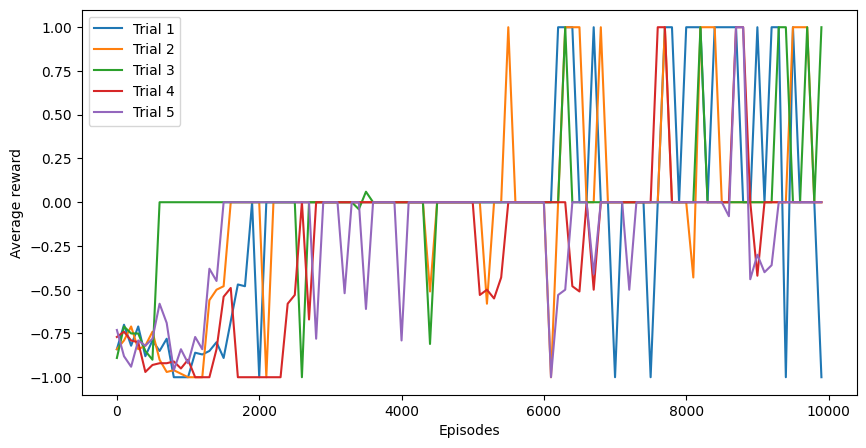

In [222]:
n = 10000
opponent = ImperfectPlayer()
rewards = {}
for i in range(5):
    np.random.seed(i)
    agent1 = Agent(alpha=0.1, alpha_decay=1, epsilon=1, epsilon_decay=1-5/n)
    agent2 = Agent(alpha=0.1, alpha_decay=1, epsilon=1, epsilon_decay=1-5/n)
    rewards[i] = self_train(agent1, agent2, opponent, n)
    agent1.inspect([None] * 9)

plot(rewards)

If we examine a single game from one of the agents, we can see that it starts off with an edge move. This is expected for minmax play but unlike the strategy learned above which favors the center position. 

Because of this move, and the opponent's tendency to take the center and then a corner, it is able to setup a nice fork to take advantage of the opponent's weakness. 

In [223]:
game = TicTacToe(player_X=agent1, player_O=opponent, verbose=True)
game.play();

-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |   |   |
-------------
Player X's turn
-------------------
|0.505|0.505|0.505|
-------------------
|0.505|0.506|0.505|
-------------------
|0.505|0.538|0.505|
-------------------
-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |(X)|   |
-------------
Player O's turn
-------------
|   |   |   |
-------------
|   |(O)|   |
-------------
|   | X |   |
-------------
Player X's turn
-------------------
|0.503|0.485|0.503|
-------------------
|0.502|  O  |0.503|
-------------------
|0.503|  X  |0.502|
-------------------
-------------
|   |   |   |
-------------
|   | O |(X)|
-------------
|   | X |   |
-------------
Player O's turn
-------------
|(O)|   |   |
-------------
|   | O | X |
-------------
|   | X |   |
-------------
Player X's turn
-------------------
|  O  |0.500|0.500|
-------------------
|0.405|  O  |  X  |
-------------------
|0.450|  X  |0.550|
-------------------
----------

## Exercise 1.2: Symmetries 

*Many tic-tac-toe positions appear different but are really the same because of symmetries. How might we amend the learning process described above to take advantage of this? In what ways would this change improve the learning process?*

*Now think again. Suppose the opponent did not take advantage of symmetries. In that case, should we? Is it true, then, that symmetrically equivalent positions should necessarily have the same value?*

We can ammend the agent's learning process above to take advantage of symmetries by updating the value of all symmetric states instead of just the states encountered during the game.


### Experiment 1: vs symmetric opponent

If the opponent's strategy is symmetric, this should allow the agent to converge on the optimal counter strategy more quickly. 

Below we repeat our initial experiment of training against the imperfect player. By enabling symmetric updates in learning agent, we are able to converge on the counter strategy earlier in most cases.

In [315]:
def compare(rewards1, rewards2, label1, label2):
    plt.figure(figsize=(10, 5))
    plt.plot(*zip(*rewards1), label=label1)
    plt.plot(*zip(*rewards2), label=label2)
    plt.xlabel("Episodes")
    plt.ylabel("Average reward")
    plt.legend()    
    plt.show()

====== Trial 1 =======


100%|██████████| 10000/10000 [00:00<00:00, 10386.37it/s]


-------------------
|1.000|0.497|0.524|
-------------------
|0.524|0.500|0.555|
-------------------
|0.498|0.678|0.891|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 9288.66it/s]


-------------------
|1.000|0.634|1.000|
-------------------
|0.634|0.500|0.634|
-------------------
|1.000|0.634|1.000|
-------------------


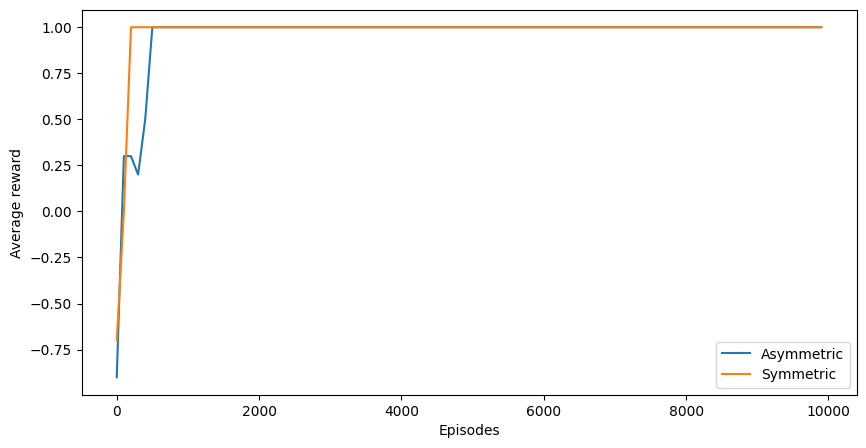

====== Trial 2 =======


100%|██████████| 10000/10000 [00:01<00:00, 9500.46it/s]


-------------------
|0.529|0.514|0.622|
-------------------
|0.512|0.499|0.554|
-------------------
|0.553|0.677|0.514|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 9457.88it/s]


-------------------
|1.000|0.687|1.000|
-------------------
|0.687|0.500|0.687|
-------------------
|1.000|0.687|1.000|
-------------------


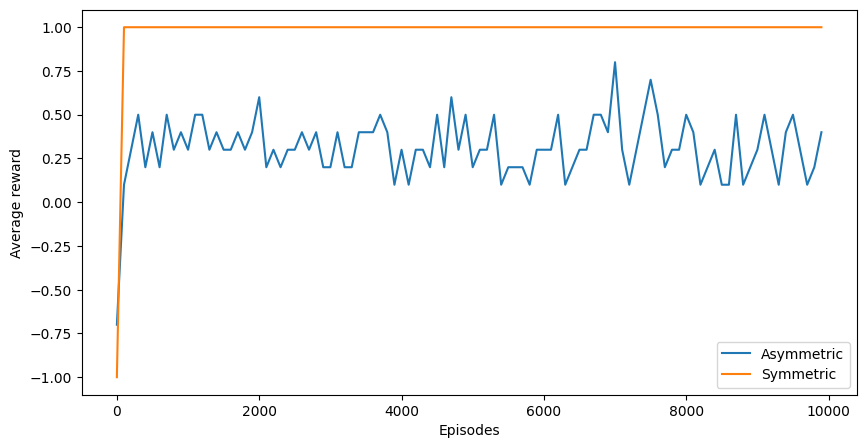

====== Trial 3 =======


100%|██████████| 10000/10000 [00:00<00:00, 10390.98it/s]


-------------------
|0.515|0.517|1.000|
-------------------
|0.617|0.499|0.496|
-------------------
|0.918|0.566|0.517|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 9245.92it/s]


-------------------
|1.000|0.639|1.000|
-------------------
|0.639|0.500|0.639|
-------------------
|1.000|0.639|1.000|
-------------------


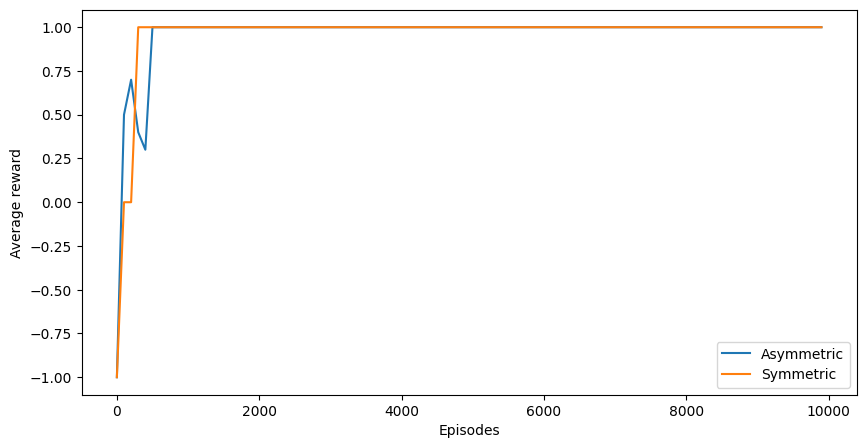

====== Trial 4 =======


100%|██████████| 10000/10000 [00:01<00:00, 9475.98it/s]


-------------------
|0.497|0.505|0.629|
-------------------
|0.661|0.500|0.496|
-------------------
|0.581|0.535|0.547|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 9411.75it/s]


-------------------
|1.000|0.641|1.000|
-------------------
|0.641|0.500|0.641|
-------------------
|1.000|0.641|1.000|
-------------------


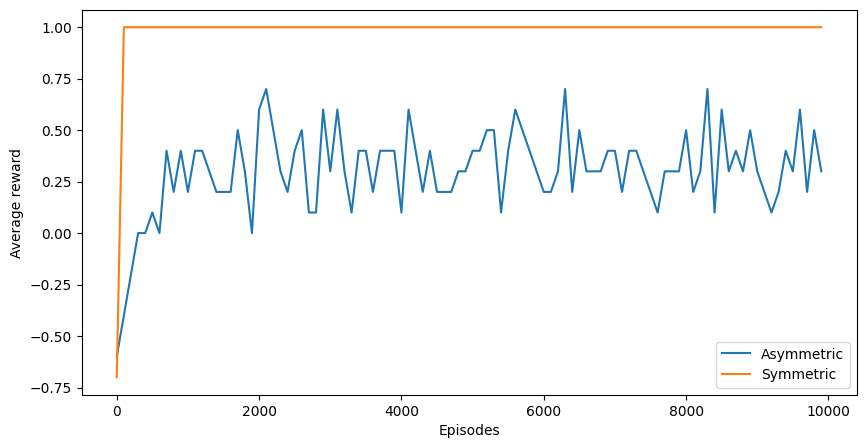

====== Trial 5 =======


100%|██████████| 10000/10000 [00:00<00:00, 10423.61it/s]


-------------------
|0.907|0.539|0.497|
-------------------
|0.635|0.499|0.497|
-------------------
|0.535|0.496|1.000|
-------------------


100%|██████████| 10000/10000 [00:01<00:00, 9506.98it/s]


-------------------
|1.000|0.657|1.000|
-------------------
|0.657|0.500|0.657|
-------------------
|1.000|0.657|1.000|
-------------------


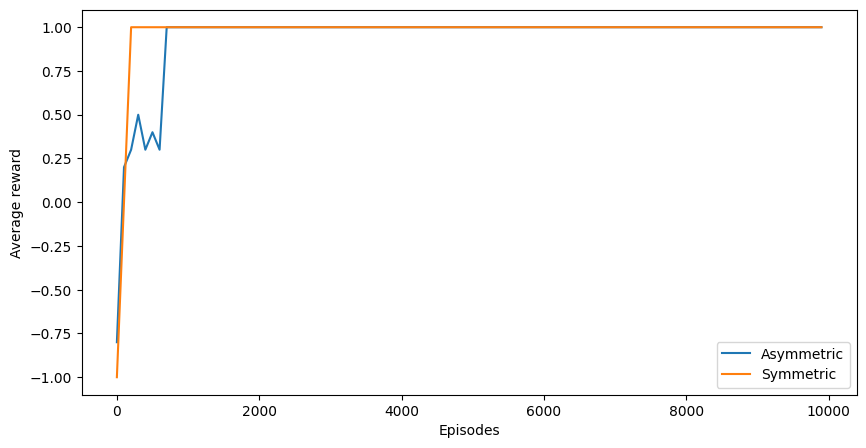

In [316]:
n = 10000
opponent = ImperfectPlayer(symmetric=True)
for i in range(5):
    print(f"====== Trial {i+1} =======")
    
    np.random.seed(i)
    agent1 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1, symmetric=False)
    rewards1 = train(agent1, opponent, n)
    agent1.inspect([None] * 9)

    np.random.seed(i)
    agent2 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1, symmetric=True)
    rewards2 = train(agent2, opponent, n)
    agent2.inspect([None] * 9)

    compare(rewards1, rewards2, "Asymmetric", "Symmetric")

### Experiment 2: vs asymmetric opponent

If the opponent's strategy is asymmetric, symmetric updating may slow or even prevent the agent from converging.

We repeat the experiment again, and find that in each trial enabling symmetry either hurts or is about the same.

====== Trial 1 =======


100%|██████████| 1000/1000 [00:00<00:00, 5527.21it/s]


-------------------
|1.000|0.499|0.500|
-------------------
|0.499|0.500|0.566|
-------------------
|0.500|0.500|0.500|
-------------------


100%|██████████| 1000/1000 [00:00<00:00, 5364.29it/s]


-------------------
|1.000|0.505|1.000|
-------------------
|0.505|0.499|0.505|
-------------------
|1.000|0.505|1.000|
-------------------


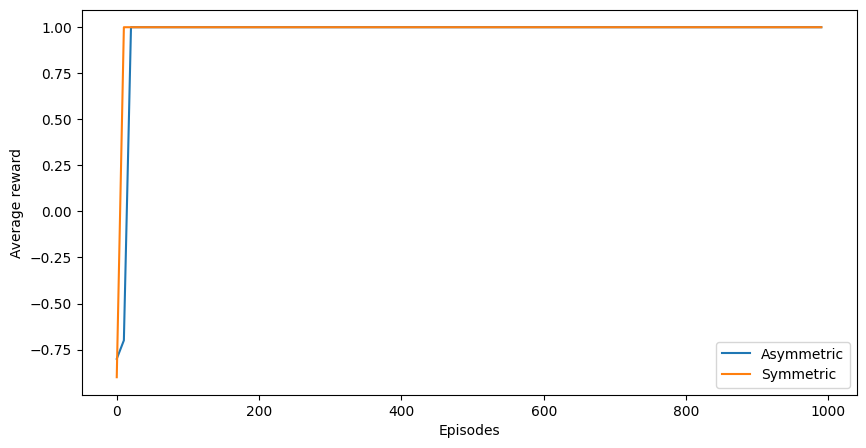

====== Trial 2 =======


100%|██████████| 1000/1000 [00:00<00:00, 5360.50it/s]


-------------------
|0.499|0.499|0.499|
-------------------
|0.499|0.500|0.499|
-------------------
|0.499|0.499|0.499|
-------------------


100%|██████████| 1000/1000 [00:00<00:00, 4569.38it/s]

-------------------
|0.500|0.499|0.500|
-------------------
|0.499|0.500|0.499|
-------------------
|0.500|0.499|0.500|
-------------------


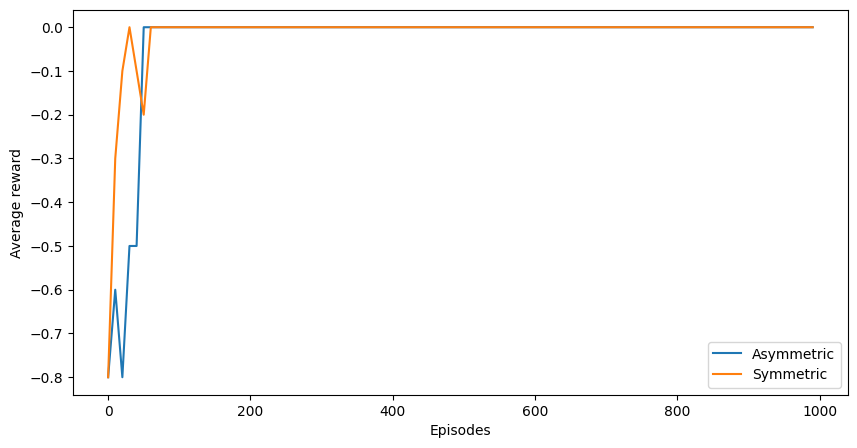

====== Trial 3 =======


100%|██████████| 1000/1000 [00:00<00:00, 5792.77it/s]


-------------------
|0.500|0.500|0.500|
-------------------
|0.500|0.500|1.000|
-------------------
|0.621|0.500|0.500|
-------------------


100%|██████████| 1000/1000 [00:00<00:00, 5399.68it/s]


-------------------
|1.000|0.500|1.000|
-------------------
|0.500|0.500|0.500|
-------------------
|1.000|0.500|1.000|
-------------------


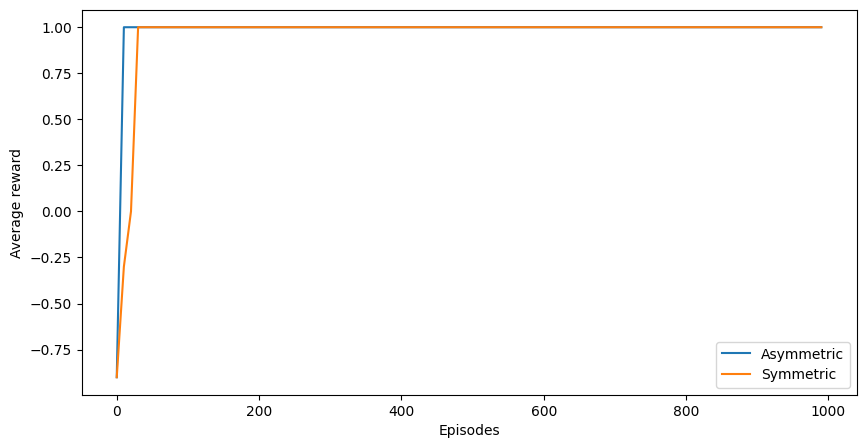

====== Trial 4 =======


100%|██████████| 1000/1000 [00:00<00:00, 5539.65it/s]


-------------------
|0.932|0.500|0.499|
-------------------
|0.499|0.499|0.499|
-------------------
|0.500|0.499|0.506|
-------------------


100%|██████████| 1000/1000 [00:00<00:00, 4615.83it/s]

-------------------
|0.497|0.496|0.497|
-------------------
|0.496|0.500|0.496|
-------------------
|0.497|0.496|0.497|
-------------------


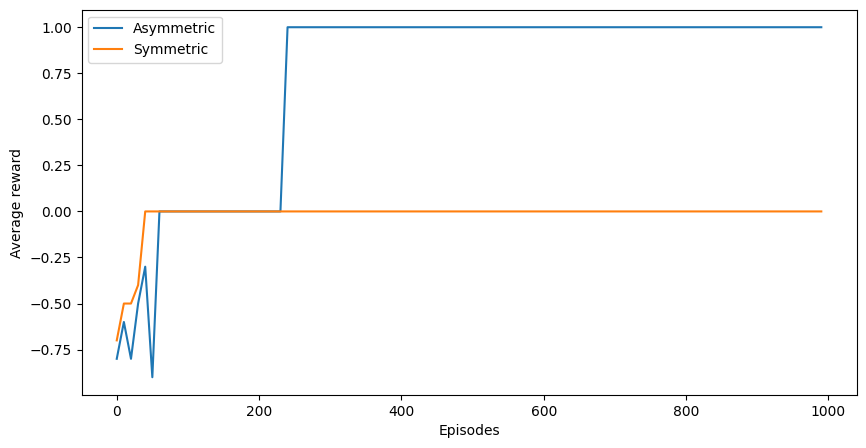

====== Trial 5 =======


100%|██████████| 1000/1000 [00:00<00:00, 6082.02it/s]


-------------------
|0.500|0.499|0.506|
-------------------
|0.499|0.499|1.000|
-------------------
|0.501|0.593|0.499|
-------------------


100%|██████████| 1000/1000 [00:00<00:00, 5267.21it/s]


-------------------
|0.908|0.499|0.908|
-------------------
|0.499|0.500|0.499|
-------------------
|0.908|0.499|0.908|
-------------------


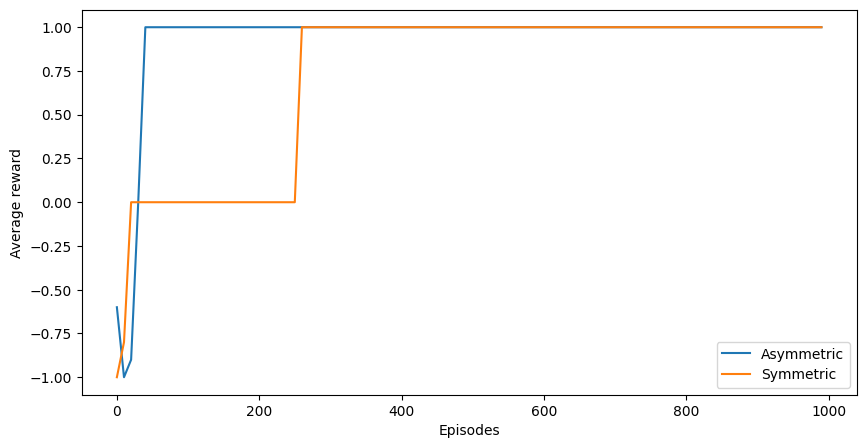

In [317]:
n = 1000
opponent = ImperfectPlayer(symmetric=False)
for i in range(5):
    print(f"====== Trial {i+1} =======")
    
    np.random.seed(i)
    agent1 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1, symmetric=False)
    rewards1 = train(agent1, opponent, n)
    agent1.inspect([None] * 9)

    np.random.seed(i)
    agent2 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1, symmetric=True)
    rewards2 = train(agent2, opponent, n)
    agent2.inspect([None] * 9)

    # zip and plot
    compare(rewards1, rewards2, "Asymmetric", "Symmetric")


## Exercise 1.3: Greedy Play 
*Suppose the reinforcement learning player was greedy, that is, it always played the move that brought it to the position that it rated the best. Might it learn to play better, or worse, than a nongreedy player? What problems might occur?*

Greedy play could result in either better or worse play, and the outcome is sensitive to randomness. 

The primary problem that could occur is that it may take longer for the agent to converge in the worst case. Imagine a scenario where there is only 1 flaw in the opponent's strategy, that only occurs very late into the game. In the worst case, the agent would need to systematically eliminate every other set of moves before it discovers the flaw.  However, once it does discover a winning set of moves, it should converge faster than a non-greedy player since there is more learning.

====== Trial 1 =======


100%|██████████| 100/100 [00:00<00:00, 1078.82it/s]


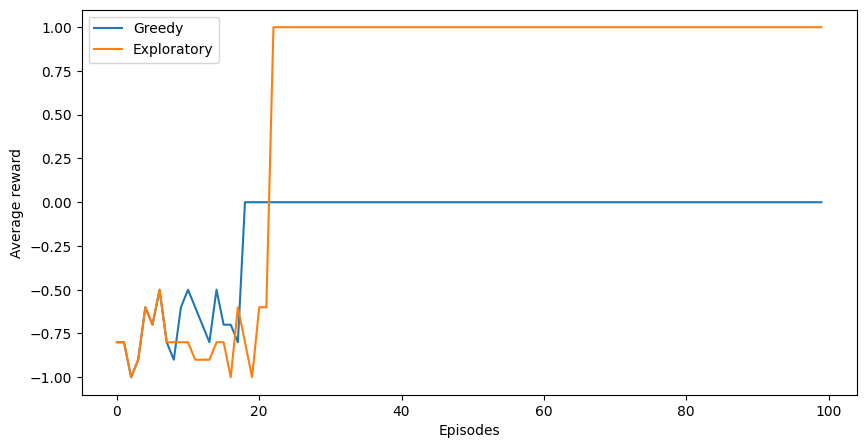

====== Trial 2 =======


100%|██████████| 100/100 [00:00<00:00, 1020.99it/s]


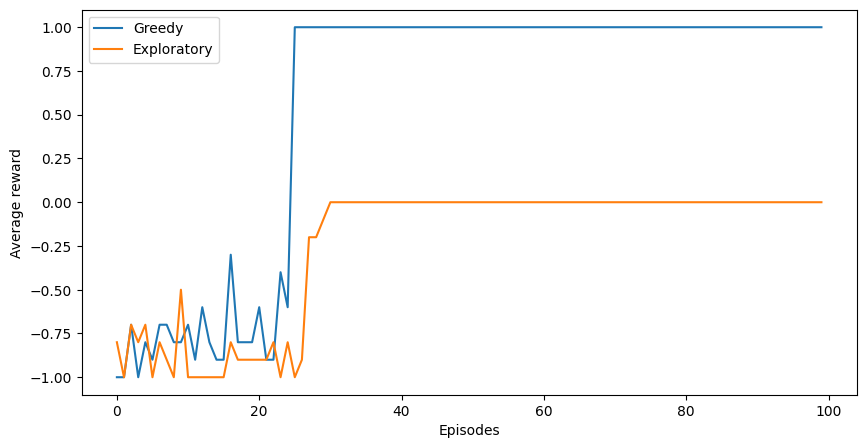

====== Trial 3 =======


100%|██████████| 100/100 [00:00<00:00, 1045.36it/s]


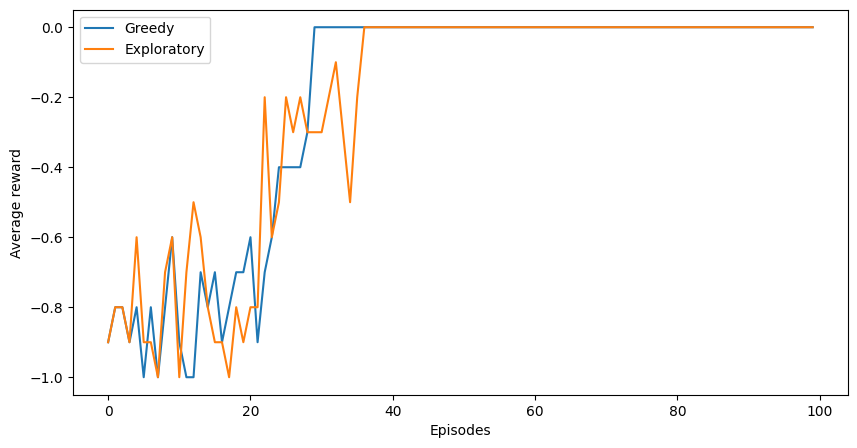

====== Trial 4 =======


100%|██████████| 100/100 [00:00<00:00, 1179.51it/s]


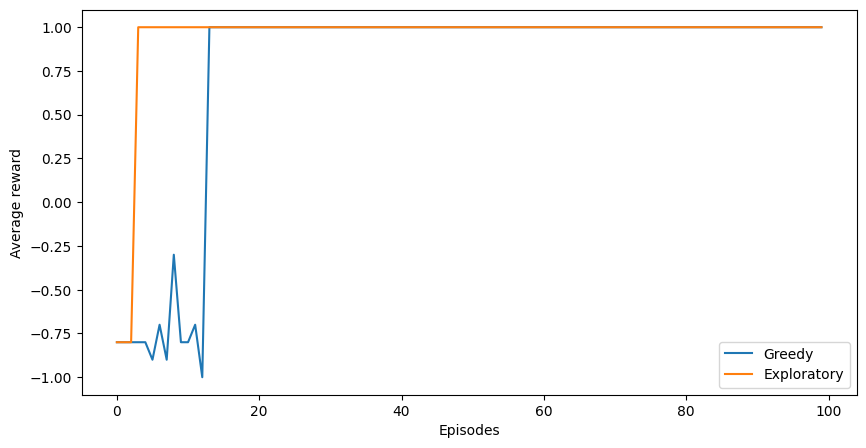

====== Trial 5 =======


100%|██████████| 100/100 [00:00<00:00, 1089.37it/s]


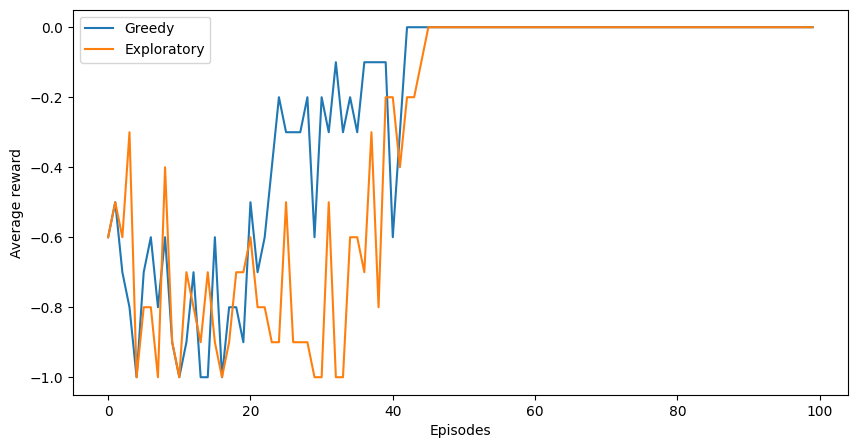

In [320]:
n = 100
opponent = ImperfectPlayer()
for i in range(5):
    print(f"====== Trial {i+1} =======")
    
    np.random.seed(i)
    agent1 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0, epsilon_decay=1)
    rewards1 = train(agent1, opponent, n)

    np.random.seed(i)
    agent2 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1)
    rewards2 = train(agent2, opponent, n)

    # zip and plot
    compare(rewards1, rewards2, "Greedy", "Exploratory")

## Exercise 1.4: Learning from Exploration 

*Suppose learning updates occurred after all moves, including exploratory moves. If the step-size parameter is appropriately reduced over time (but not the tendency to explore), then the state values would converge to a different set of probabilities. What (conceptually) are the two sets of probabilities computed when we do, and when we do not, learn from exploratory moves? Assuming that we do continue to make exploratory moves, which set of probabilities might be better to learn? Which would result in more wins?* 

The value learned if we do not learn from exploratory moves is the expected probability of winning by following the greedy policy. The value learned if we do learn from exploratory moves is the expected probablity of wiining by following the non-greedy policy.

If we continue to make exploratory moves, then we are following the non-greedy policy, so it is better to learn from exploration since this better reflects our actual policy. In the trials below, we see that learning from exploration during training (where we are following the non-greedy policy), it is always better to learn from exploration.

Learning from exploration could help or hurt but is sensitive to randomness. Imagine if the exploratory move happened to be the ideal move, learning from it will help accelerate convergence.

====== Trial 1 =======


100%|██████████| 100/100 [00:00<00:00, 1093.65it/s]


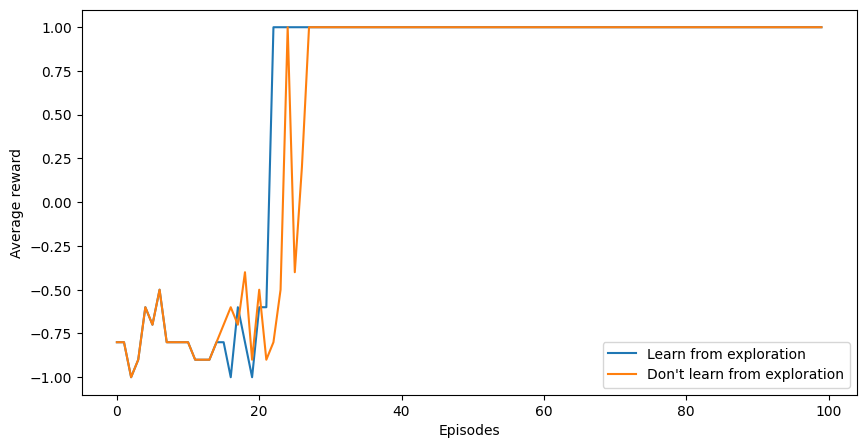

====== Trial 2 =======


100%|██████████| 100/100 [00:00<00:00, 1180.25it/s]


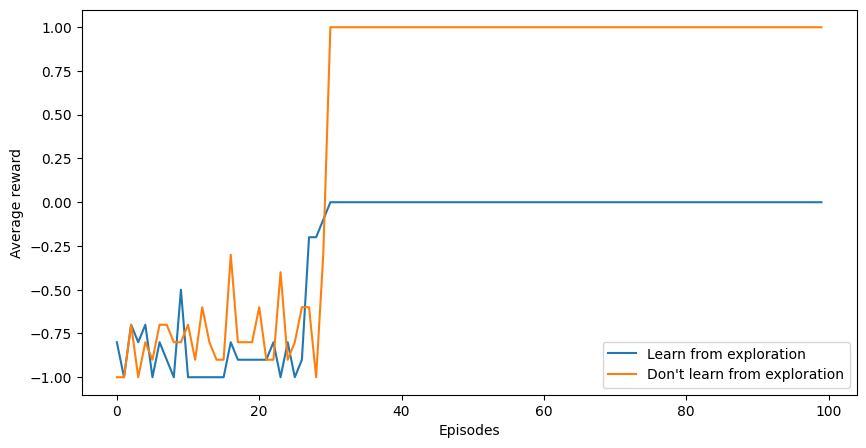

====== Trial 3 =======


100%|██████████| 100/100 [00:00<00:00, 1166.72it/s]


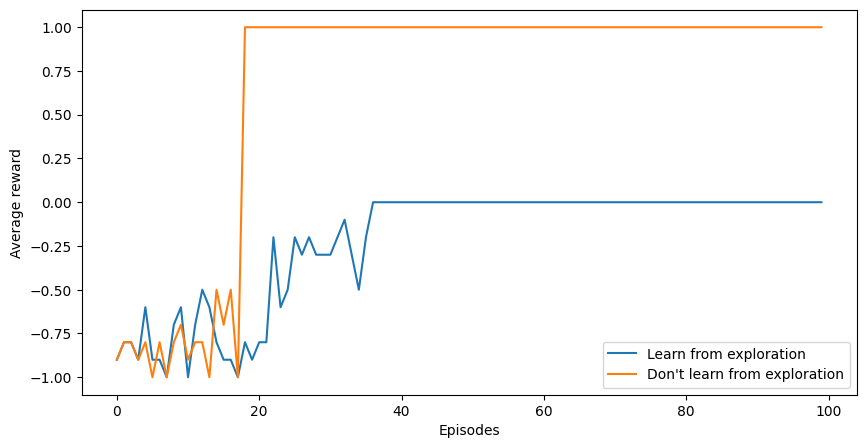

====== Trial 4 =======


100%|██████████| 100/100 [00:00<00:00, 958.78it/s]


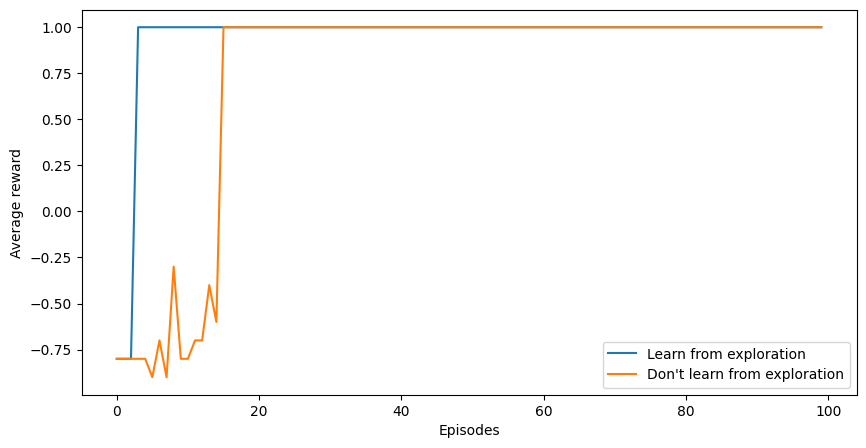

====== Trial 5 =======


100%|██████████| 100/100 [00:00<00:00, 987.95it/s]


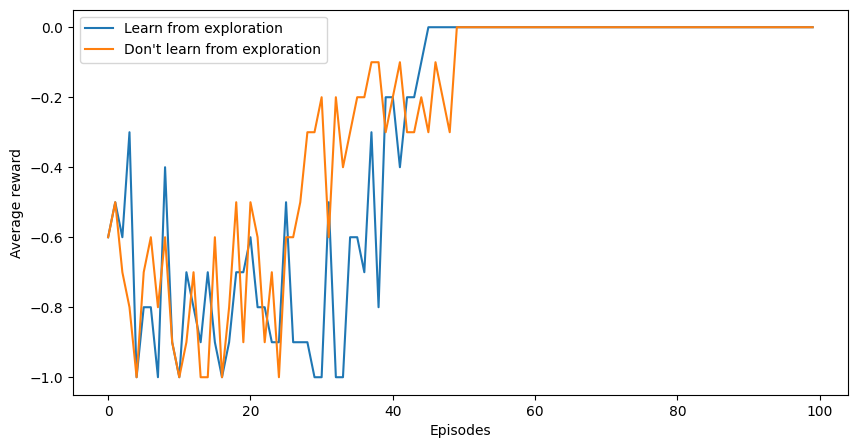

In [323]:
n = 100
opponent = ImperfectPlayer()
for i in range(5):
    print(f"====== Trial {i+1} =======")
    
    np.random.seed(i)
    agent1 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1, learn_from_exploration=False)
    rewards1 = train(agent1, opponent, n)

    np.random.seed(i)
    agent2 = Agent(alpha=0.1, alpha_decay=1-5/n, epsilon=0.1, epsilon_decay=1, learn_from_exploration=True)
    rewards2 = train(agent2, opponent, n)

    # zip and plot
    compare(rewards1, rewards2, "Learn from exploration", "Don't learn from exploration")

### Exercise 1.5: Other Improvements 
*Can you think of other ways to improve the reinforcement learning player? Can you think of any better way to solve the tic-tac-toe problem as posed?* 

Instead of initializing with 0.5s, we can initialize with the minmax values and learn from there.